# Finding open clusters in the Gaia catalog

Open clusters are relatively young stellar associations with members in the order of ~100. They are favored targets for astronomers, since they are formed at the same time, so if you get e.g. an age estimation a few of them, you have an age for all the members. Field stars are much trickier from this sense, their age can be usually just roughly guessed as they don't have that info on a sign written under them (or if they have, the letters are too small to read).

So, how do we identify an open cluster? With globular clusters the job is easy, as they are... *globular*. Open clusters are more tricky - some members can be easily identified, but for a better job we should look for stars roughly at the same distance moving together. 

We'll be looking up clusters of different ages, check their TESS light curves, and see how their flaring activity changes during their life.

The Gaia catalog can be queried in many ways:
* directly from their website: https://gea.esac.esa.int/archive/
* using the [VizieR](https://vizier.u-strasbg.fr/viz-bin/VizieR) service in the `I/345` catalog
* using the [Virtual Observatory (VO)](https://wiki.ivoa.net/twiki/bin/view/IVOA/IvoaApplications) and the TAP (Table Access Protocol), e.g. with `topcat` 
* in python/astroquery

depending on your skills/mood/actual needs. I'd suggest to try them all. Easier queries could be done quickly in VizieR, the website can be used anywhere without prerequisites, `topcat` can be helpful to set up your queries, since it has synchronous/asynchronous/quick look mode, and it shows you the available tables and columns. The result can be saved in various formats and you can work them later as you like.

![topcat](./topcat.png)

More complex queries can be done in 
the [Astronomical Data Query Language (ADQL)](http://www.ivoa.net/documents/REC/ADQL/ADQL-20081030.pdf),
which is the language used by the International Virtual Observatory Alliance (IVOA) to represent astronomy queries
posted to VO services.
ADQL is a language that is *something almost, but not quite entirely unlike* SQL, the most notable difference is that it includes functions for spherical geometry, which would have a limited use in other databases.

A typical query looks like this:

`SELECT TOP 1000 * FROM gaiadr1.gaia_source`

or

`SELECT
   TOP 1000
   solution_id, source_id, random_index
   FROM gaiadr1.gaia_source`
   
More examples can be found on the [Gaia site](https://gea.esac.esa.int/archive-help/index.html), 
the [Gaia ADQL cookbook](https://www.gaia.ac.uk/data/gaia-data-release-1/adql-cookbook), or in `topcat`, too.

Some crossmatches with other databases is already done, so if you want a query that uses e.g. the 2MASS or WISE surveys with Gaia, you can join the two tables (this is just copied from topcat, probably works):

`SELECT TOP 10 gaia.source_id,
	gaia.phot_g_mean_mag + 5 * log10(gaia.parallax) - 10 AS g_mag_abs ,
	gaia.phot_g_mean_mag - tmass.ks_m AS g_min_ks 
FROM gaiadr1.tgas_source AS gaia
INNER JOIN gaiadr1.tmass_best_neighbour AS xmatch
	ON gaia.source_id = xmatch.source_id
INNER JOIN gaiadr1.tmass_original_valid AS tmass
	ON tmass.tmass_oid = xmatch.tmass_oid
WHERE gaia.parallax/gaia.parallax_error >= 5 AND
	ph_qual = 'AAA' AND
	sqrt(power(2.5 / log(10) * gaia.phot_g_mean_flux_error
		/ gaia.phot_g_mean_flux, 2) ) <= 0.05 AND
	sqrt(power(2.5/log(10)*gaia.phot_g_mean_flux_error
		/ gaia.phot_g_mean_flux, 2) + power(tmass.ks_msigcom, 2)) <= 0.05`

# Our sample

Our sample case will be three open clusters with different ages:



|Name|RA|Dec|Vmag|size|N|distance (pc)\*|age|
|-|-|-|-|-|-|:-:|-|
|Blanco 1 |00 04.3 | -29 56  |   4.5 |  90' | 30  |  270 | 100
|NGC 6633 |18 27.7 | +06 34  | 4.6  | 20' | 30 |  380| 660
|NGC  752 |01 57.8 | +37 41  | 5.7  | 75' | 60 | 455| 2000

\*: Dias W, et al. (2002). New catalogue of optically visible open clusters and candidates. Astron and Astrophys, 389, 871.

These were selected from [Wikipedia](https://en.wikipedia.org/wiki/List_of_open_clusters) and a [list of open clusters](http://www.atlasoftheuniverse.com/openclus.html) to cover a wide range of ages. As the member numbers are pre-Gaia values, we expect to find a larger number here. 

Along the way we can cheat and compare our findings with a recent [open cluster study based on Gaia](https://www.aanda.org/articles/aa/full_html/2018/10/aa33476-18/aa33476-18.html)

#### The code starts here

We'll use `astroquery` here to do our ADQL queries. `astropy` provides some helper functions for handling and converting coordinates. Some of these are completely unnecessary here (like degree -> minute conversion), they are here only as an example. These queries have often more warning outputs as you'd likely want to see, these can be suppressed with the `warnings` package.

In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.units import Quantity
from astroquery.gaia import Gaia

Created TAP+ (v1.2.1) - Connection:
	Host: gea.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443
Created TAP+ (v1.2.1) - Connection:
	Host: geadata.esac.esa.int
	Use HTTPS: True
	Port: 443
	SSL Port: 443


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [4]:
tables = Gaia.load_tables(only_names=True)
for table in (tables):
    print (table.get_qualified_name())

INFO: Retrieving tables... [astroquery.utils.tap.core]
INFO: Parsing tables... [astroquery.utils.tap.core]
INFO: Done. [astroquery.utils.tap.core]
external.external.apassdr9
external.external.gaiadr2_geometric_distance
external.external.galex_ais
external.external.ravedr5_com
external.external.ravedr5_dr5
external.external.ravedr5_gra
external.external.ravedr5_on
external.external.sdssdr13_photoprimary
external.external.skymapperdr1_master
external.external.tmass_xsc
public.public.hipparcos
public.public.hipparcos_newreduction
public.public.hubble_sc
public.public.igsl_source
public.public.igsl_source_catalog_ids
public.public.tycho2
public.public.dual
tap_config.tap_config.coord_sys
tap_config.tap_config.properties
tap_schema.tap_schema.columns
tap_schema.tap_schema.key_columns
tap_schema.tap_schema.keys
tap_schema.tap_schema.schemas
tap_schema.tap_schema.tables
gaiadr1.gaiadr1.aux_qso_icrf2_match
gaiadr1.gaiadr1.ext_phot_zero_point
gaiadr1.gaiadr1.allwise_best_neighbour
gaiadr1.gaiad

Note: warnings are suppressed

In [5]:
coord=SkyCoord('00 04 24', '-29 56 00', unit=(u.hourangle, u.deg))
coord=SkyCoord('18 27 42', '+06 34 00', unit=(u.hourangle, u.deg))
coord=SkyCoord('01 57 50', '+37 41 00', unit=(u.hourangle, u.deg))


radius = 3*90 * u.arcmin #that's absolutely unnecessary here, just for fun

print(coord.ra.hms, coord.ra.deg)


hms_tuple(h=1.0, m=57.0, s=50.00000000000057) 29.45833333333333


#### This is our actual query

Using Gaia DR2 will give a _lot_ of results, and take a while to run. A simple query might have faulty values, it's generally a good idea to filter these based on their errors. There might be pre-calculated columns for these, e.g. `gaia_source.parallax_over_error`, that will make the query faster, but the DR1 table doesn't necessarily have these, so we'll calculate these on the fly. This might cause a server timeout, though...

In [6]:
job = Gaia.launch_job_async("SELECT * \
FROM gaiadr2.gaia_source \
WHERE CONTAINS(POINT('ICRS',gaiadr2.gaia_source.ra,gaiadr2.gaia_source.dec),CIRCLE('ICRS',"+\
                            str(coord.ra.deg)+","+str(coord.dec.deg)+","+str( radius.to(u.deg).value )+" \
                            ))=1 \
AND abs(gaiadr2.gaia_source.pmra_error/gaiadr2.gaia_source.pmra)<0.10 \
AND abs(gaiadr2.gaia_source.pmdec_error/gaiadr2.gaia_source.pmdec)<0.10 \
AND gaiadr2.gaia_source.pmra IS NOT NULL AND abs(gaiadr2.gaia_source.pmra)>0 \
AND gaiadr2.gaia_source.pmdec IS NOT NULL AND abs(gaiadr2.gaia_source.pmdec)>0 \
AND gaiadr2.gaia_source.parallax/gaiadr2.gaia_source.parallax_error>10 \
                            ;" \
, dump_to_file=True)

print (job)

Jobid: 1594825685870O
Phase: COMPLETED
Owner: None
Output file: async_20200715170805.vot
Results: None


In [7]:
r=job.get_results()

### Let's see the result!

We'll plot the proper motions, colored by the distance (parallax), and we'll find the cluster!

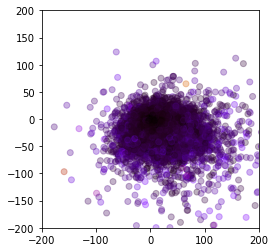

In [8]:
plt.scatter(r['pmra'], 
            r['pmdec'], 
            c=(r['parallax']), 
            cmap=plt.cm.gnuplot,
            alpha=0.3)
plt.xlim(-200,200)
plt.ylim(-200,200)

plt.gca().set_aspect(1) #I know...

OK, there are too many targets, let's try something else. Let's just check a histogram of the distances, maybe we'll see our stars there. Try changing the bin size in the histogram!

(array([2.485e+03, 8.090e+03, 9.289e+03, 8.740e+03, 7.942e+03, 7.111e+03,
        5.788e+03, 4.388e+03, 3.056e+03, 1.961e+03, 1.229e+03, 6.520e+02,
        3.800e+02, 1.950e+02, 9.100e+01, 8.700e+01, 3.400e+01, 2.600e+01,
        2.100e+01, 1.900e+01, 5.000e+00, 9.000e+00, 7.000e+00, 2.000e+00,
        2.000e+00]),
 array([  10.33917561,  192.91625293,  375.49333025,  558.07040756,
         740.64748488,  923.2245622 , 1105.80163951, 1288.37871683,
        1470.95579414, 1653.53287146, 1836.10994878, 2018.68702609,
        2201.26410341, 2383.84118073, 2566.41825804, 2748.99533536,
        2931.57241268, 3114.14948999, 3296.72656731, 3479.30364462,
        3661.88072194, 3844.45779926, 4027.03487657, 4209.61195389,
        4392.18903121, 4574.76610852]),
 <a list of 25 Patch objects>)

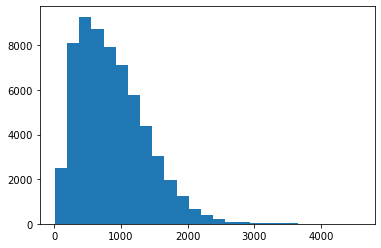

In [9]:
plt.hist(1000./r['parallax'], 25)
#plt.xlim(0,1000)


OK, that did no good. We'll use our cheat option, and compare our results from that paper and its tables. You could (and should try to!) check the table on [VizieR](https://vizier.u-strasbg.fr/) under this catalog: `J/A+A/618/A93`. Once you did your query, you can transfer your results directly to most of the Virtual Observatory tools, e.g. `topcat` for quick analysis, plots, further filtering, or just to save it in various formats.

Alternatively you can access VizieR via `astroquery`. Note, that for _reasons_ it returns a list, and we need its first element. The query constraints are not self-explanatory either, consult the VizieR website for details. Once we have the query you can use/filter its content as a _Table_. 

In [10]:
from astroquery.vizier import Vizier
cluster_table = Vizier(catalog='J/A+A/618/A93/table1', 
             columns=['Cluster','RAJ2000','DEJ2000','r50','Nstars','pmRA','pmDE']).query_constraints(Cluster='~|Blanco*1|NGC*6633|NGC*752')[0]
#agn = Vizier(catalog="VII/258/vv10",columns=['*', '_RAJ2000', '_DEJ2000']).query_constraints(Vmag="10.0..11.0")[0]

cluster_table
#cluster_table[ cluster_table['Cluster']=='Blanco_1' ]


Cluster,RAJ2000,DEJ2000,r50,Nstars,pmRA,pmDE
,deg,deg,deg,,mas / yr,mas / yr
bytes17,float32,float32,float32,int16,float32,float32
Blanco_1,0.853,-29.958,0.699,381,18.739,2.602
NGC_6633,276.845,6.615,0.360,187,1.198,-1.811
NGC_752,29.223,37.794,0.485,240,9.810,-11.713


Let's compare our findings with the other table of the same paper - locations and proper motions/distances -, that has the open cluster members! Try changing the `vmin`-`vmax` values in the scatter plot to see, why we didn't find the cluster members previously.

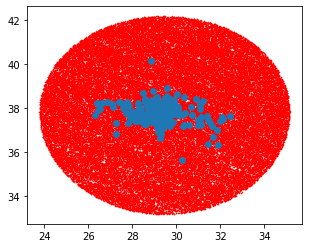

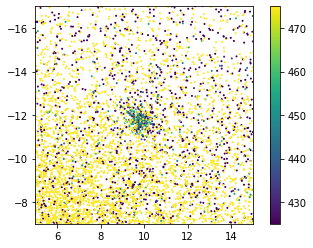

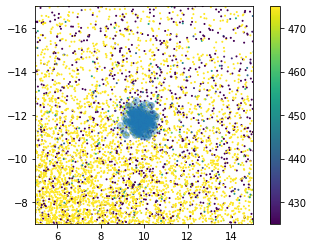

In [11]:
from astroquery.vizier import Vizier
cluster_table = Vizier(catalog='J/A+A/618/A93/members', 
             columns=['*'],row_limit=999).query_constraints(Cluster='~|NGC*752')[0]
fig1=plt.figure()
plt.scatter(r['ra'], 
            r['dec'], 
            c='r',
            s=0.3)
/plt.scatter cluster_table['RA_ICRS'] cluster_table['DE_ICRS']
plt.gca().set_aspect(1)

fig2=plt.figure()

xrange=(5,15)
yrange=(-7,-17)
#fig2, axs =plt.subplots(1,2, figsize=(10,5),subplot_kw={"aspect":"equal"})
plt.scatter(r['pmra'], 
            r['pmdec'], 
            c=(1000/r['parallax']), 
            cmap=plt.cm.viridis,
            vmin=425,
            vmax=475,
            s=1)
plt.xlim(xrange)
plt.ylim(yrange)
plt.colorbar()
plt.gca().set_aspect(1)

fig3=plt.figure()

plt.scatter(r['pmra'], 
            r['pmdec'], 
            c=(1000/r['parallax']), 
            cmap=plt.cm.viridis,
            vmin=425,
            vmax=475,
            s=1)
plt.colorbar()
plt.gca().set_aspect(1)

/plt.scatter cluster_table['pmRA'] cluster_table['pmDE'] alpha=0.3
plt.xlim(xrange)
plt.ylim(yrange)

#axs[1].set_aspect(1)
xrange=(5,15)
yrange=(-7,-17)
#axs[0].set_xlim(xrange)
#axs[0].set_ylim(yrange)
#axs[1].set_xlim(xrange)
#axs[1].set_ylim(yrange)


Now that we agreed on the list of cluster members, save them in a table for further use. We'll use that list to get their TESS observations.

(-7, -17)

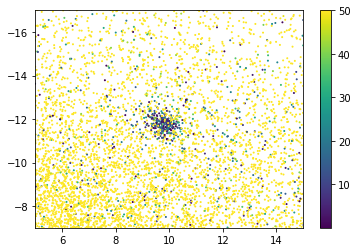

In [12]:
plt.scatter(r['pmra'], 
            r['pmdec'], 
            c=np.abs(455-1000/r['parallax']), 
            cmap=plt.cm.viridis, vmax=50,s=1)
plt.colorbar()
plt.xlim(xrange)
plt.ylim(yrange)


We'll create a subset of the points around the open cluster for playing around a bit.

In [13]:
sub=r[  (r['pmra']<15)*(r['pmra']>5)*(r['pmdec']<-7)*(r['pmdec']>-17) ]


As a fun experiment, you could try to find the open cluster automatically by a clustering algorithm. There are several of these included in the 
[`sklearn` package](https://scikit-learn.org/stable/modules/clustering.html#clustering). 
Try different algorithms, settings and data scaling methods. You can try to drop/vary some of the input data, too.

In [14]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import preprocessing

X=np.array([sub['pmra'], sub['pmdec'], np.abs(1000/sub['parallax']) ]).T


Xscaler = preprocessing.MinMaxScaler().fit(X)
X_scaled = Xscaler.transform(X)

kmeans = GaussianMixture(n_components=5, random_state=42).fit(X_scaled)
kmeans.predict(X_scaled)

array([0, 0, 4, ..., 3, 0, 0])

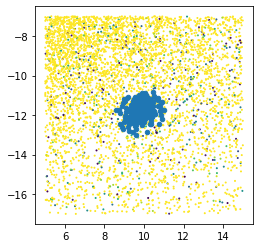

In [15]:
label=1
plt.scatter( sub['pmra'], sub['pmdec'], c=np.abs(455-1000/sub['parallax']), vmin=0,vmax=50, s=1,cmap=plt.cm.viridis)
plt.scatter( sub['pmra'][kmeans.predict(X_scaled)==label], sub['pmdec'][kmeans.predict(X_scaled)==label],  s=20)
plt.gca().set_aspect(1)


We'll just stick to a basic manual selection in the end based on the literature proper motion and distance values

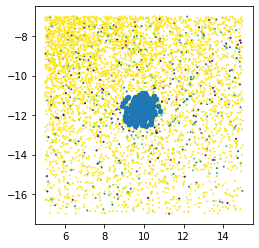

In [16]:
(pmra0, pmdec0) = (9.810, -11.713)
cond1 = np.sqrt((sub['pmra']-pmra0)**2 + (sub['pmdec']-pmdec0)**2) < 1
cond2 = np.abs(455-1000/sub['parallax']) < 50
members = cond1 *cond2
plt.scatter( sub['pmra'], sub['pmdec'], c=np.abs(455-1000/sub['parallax']), vmin=0,vmax=50, s=1,cmap=plt.cm.viridis)
plt.scatter( sub['pmra'][members], sub['pmdec'][members],  s=20)

plt.gca().set_aspect(1)

Let's check on the color-magnitude of our cluster if we already have everything for it, and save the member list for the further steps.

Text(0, 0.5, '$G$')

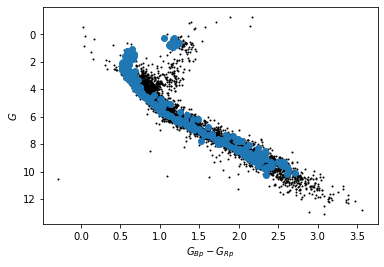

In [34]:
plt.scatter(    
    sub["bp_rp"],
    sub["phot_g_mean_mag"] - 5*np.log10( 1000/sub["parallax"]) + 5 ,
    c="#000000",
    s=1
)

plt.scatter(    
    sub[members]["bp_rp"],
    sub[members]["phot_g_mean_mag"] - 5*np.log10( 1000/sub[members]["parallax"]) + 5
)
plt.gca().invert_yaxis()
plt.xlabel('$G_{Bp}-G_{Rp}$')
plt.ylabel('$G$')

In [18]:
outfile="members.ngc752.json"
sub[members].write(outfile, format="pandas.json")

Before exiting, we'll read back the file for safety

In [20]:
from astropy.table import Table
foo=Table.read(outfile, format="pandas.json")
print(foo)

    solution_id             designation         ... epoch_photometry_url
------------------- --------------------------- ... --------------------
1635721458409799680 Gaia DR2 319390952296062080 ...                   --
1635721458409799680 Gaia DR2 342477226146028928 ...                   --
1635721458409799680 Gaia DR2 342451215824120576 ...                   --
1635721458409799680 Gaia DR2 342474443007226240 ...                   --
1635721458409799680 Gaia DR2 342484269892379264 ...                   --
1635721458409799680 Gaia DR2 342480004988278784 ...                   --
1635721458409799680 Gaia DR2 342459256002883584 ...                   --
1635721458409799680 Gaia DR2 342469804442558464 ...                   --
1635721458409799680 Gaia DR2 342483234804070784 ...                   --
1635721458409799680 Gaia DR2 342457160058842624 ...                   --
                ...                         ... ...                  ...
1635721458409799680 Gaia DR2 331137069376323584 ...

#### Note

Just in case you'd want to handle several clusters in the same way, it might be a good idea to create a function or class for them